Import package + model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cobra
from cobra.io import (
    load_json_model,
    save_json_model,
    load_matlab_model,
    save_matlab_model,
    read_sbml_model,
    write_sbml_model,
)
from cobra.flux_analysis import flux_variability_analysis
from scipy.integrate import solve_ivp
from tqdm import tqdm

In [2]:
M_xanthus = read_sbml_model("../M_xanthus_model.sbml") # import the Myxococcus xanthus model
M_xanthus

Name,myxo_model
Memory address,7db7c98a5010
Number of metabolites,1280
Number of reactions,1367
Number of genes,1192
Number of groups,0
Objective expression,1.0*OF_BIOMASS - 1.0*OF_BIOMASS_reverse_80d2e
Compartments,"c, e"


In [3]:
E_coli = read_sbml_model("../E_coli_model.sbml")
E_coli

Name,iML1515
Memory address,7db7fbb287d0
Number of metabolites,1877
Number of reactions,2714
Number of genes,1516
Number of groups,0
Objective expression,1.0*BIOMASS_Ec_iML1515_core_75p37M - 1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685
Compartments,"cytosol, extracellular space, periplasm"


**Adding Reactions**

In [4]:
Biomass_e = cobra.Metabolite(
    'Biomass_e',
    formula='BIOMASS',
    name='Biomass [e]',
    compartment='e')

M_xanthus.add_metabolites(Biomass_e) # add M_xanthus.metabolites.Biomass_e

M_xanthus.add_boundary(M_xanthus.metabolites.get_by_id("Biomass_e"), type="exchange") #add the exchange reaction for Biomass_e

Reaction identifier,EX_Biomass_e
Name,Biomass [e] exchange
Memory address,0x7db7c6c0c260
Stoichiometry,Biomass_e <=> Biomass [e] <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


**Dynamic environment**

In [5]:
M_xanthus.reactions.EX_glc_D_e.id = 'EX_glc__D_e'

In [ ]:
t = 0
tf = 50
steps = 0.5
time_point = [0]
it = 1
y = [100, 100, 100, 100] # give the number of metabolites in the environment
biomass = 0 # quantities of Biomass in the environment
fluxes_E = []
fluxes_M = []

reactions_list_E_coli = [] # get all reaction of E_coli model
for reaction in E_coli.reactions:
    reactions_list_E_coli.append(reaction.id)

reactions_list_M_xanthus = []
for reaction in M_xanthus.reactions:
    reactions_list_M_xanthus.append(reaction.id)


def add_dynamic_bounds(model, y, biomass):
    """Use external concentrations to bound the uptake flux of glucose. \n
    :param sbml model: The model you want to add dynamic bounds. \n
    :param list(int) y: A list of the metabolite quantities in environment. In order: glucose, oxygen, amonium, isoleucine.
    :param int biomass: Quantities of Biomass in the environment.
    """
    glucose, oxygen, ammonium, isoleucine = y  # expand the boundary species (Can put more)

    glucose_max_import = -10 * glucose / (5 + glucose) # calculate the max import value for the metabolites
    oxygen_max_import = -10 * oxygen / (5 + oxygen)
    ammonium_max_import = -10 * ammonium / (5 + ammonium)
    isoleucine_max_import = -10 * isoleucine / (5 + isoleucine)
    biomass_max_import = -10 * biomass / (5 + biomass)

    E_coli.reactions.EX_glc__D_e.lower_bound = glucose_max_import  # change the limit of importation with the mex import

    model.reactions.EX_o2_e.lower_bound = oxygen_max_import
    model.reactions.EX_nh4_e.lower_bound = ammonium_max_import

    M_xanthus.reactions.EX_ile_L_e.lower_bound = isoleucine_max_import
    M_xanthus.reactions.EX_glu_L_e.bounds = [0,0]
    M_xanthus.reactions.EX_Biomass_e.lower_bound = biomass_max_import


def update_metabolites(fluxes, y, biomass):
    """Updtate the metabolites quantities depending of the fluxes. \n
    :param list(int) fluxes: The list of the fluxes. \n
    :param list(int) y: A list of the metabolite quantities in environment. In order: glucose, oxygen, amonium, isoleucine. \n
    :param int biomass: Quantities of Biomass in the environment.
    """
    glucose, oxygen, ammonium, isoleucine = y  # expand the boundary species (Can put more)

    glucose = glucose + fluxes["EX_glc__D_e"]  # calculate the number of metabolites
    oxygen = oxygen + fluxes["EX_o2_e"]
    ammonium = ammonium + fluxes["EX_nh4_e"]
    if "EX_ile_L_e" in fluxes:
        isoleucine = isoleucine + fluxes["EX_ile_L_e"]
    if "BIOMASS_Ec_iML1515_core_75p37M" in fluxes:
        biomass = biomass + fluxes["BIOMASS_Ec_iML1515_core_75p37M"]
    if "EX_Biomass_e" in fluxes:
        biomass = biomass + fluxes["EX_Biomass_e"]
    
    if glucose < 0:
        glucose = 0 #if the value goes below zero set the number of metaboltie to zero
    if oxygen < 0:
        oxygen = 0
    if ammonium < 0:
        ammonium = 0
    if isoleucine < 0:
        isoleucine = 0
    if biomass < 0:
        biomass = 0

    y = (glucose, oxygen, ammonium, isoleucine)  # changing the value of the metabolites
    return y, biomass


with tqdm(total=tf) as pbar:
    while t < tf:
        add_dynamic_bounds(E_coli, y, biomass) ## For Escherichia coli
        FBA_1 = E_coli.optimize()  # perform flux balance analysis (FBA)
        fluxes_E_coli = FBA_1.fluxes.get(reactions_list_E_coli)  # store the fluxes of the FBA
        fluxes_E_coli *= 0.1  # multiply by Biomass Concentration to get flux
        fluxes_E.append(fluxes_E_coli)  # store all the fluxes
        y, biomass = update_metabolites(fluxes_E_coli, y, biomass)

        add_dynamic_bounds(M_xanthus, y, biomass) ## For Myxococcus xanthus
        FBA_2 = M_xanthus.optimize() 
        fluxes_M_xanthus = FBA_2.fluxes.get(reactions_list_M_xanthus) 
        fluxes_M_xanthus *= 0.1 
        fluxes_M.append(fluxes_M_xanthus) 
        y, biomass = update_metabolites(fluxes_M_xanthus, y, biomass)

        time_point.append(time_point[it - 1] + steps) 
        it += 1
        t += steps
        pbar.update(steps)

100%|█████████▉| 49.80000000000017/50 [00:36<00:00,  1.39it/s] /home/mickael/miniconda3/envs/Micka_Predation/lib/python3.13/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 50.00000000000017/50 [00:36<00:00,  1.36it/s]


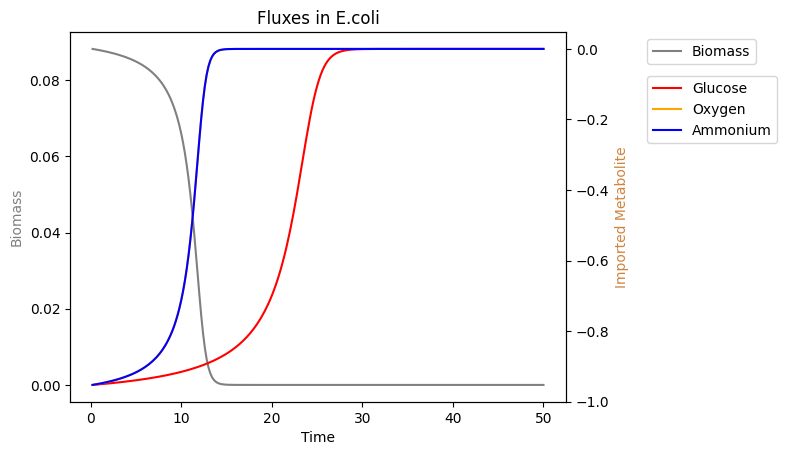

In [19]:
glucose = []
oxygen = []
ammonium = []
biomass = []

for i in fluxes_E:
    glucose.append(i["EX_glc__D_e"])
    biomass.append(i["BIOMASS_Ec_iML1515_core_75p37M"])
    oxygen.append(i["EX_o2_e"])
    ammonium.append(i["EX_nh4_e"])

ax = plt.subplot(111)
ax.plot(time_point[1:], biomass, color="gray", label="Biomass")
ax2 = plt.twinx(ax)
ax2.plot(time_point[1:], glucose, color="red", label="Glucose")
ax2.plot(time_point[1:], oxygen, color="orange", label="Oxygen")
ax2.plot(time_point[1:], ammonium, color="blue", label="Ammonium")
ax.set_ylabel("Biomass", color="gray")
ax2.set_ylabel("Imported Metabolite", color="peru")
ax.set_xlabel('Time')

ax.set_title("Fluxes in E.coli")
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")
ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left")

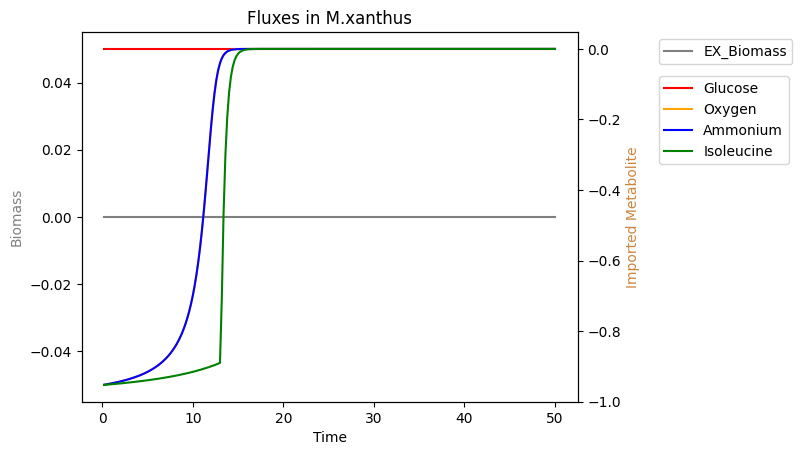

In [22]:
glucose = []
oxygen = []
ammonium = []
isoleucine = []
biomass = []

for i in fluxes_M:
    glucose.append(i["EX_glc__D_e"])
    biomass.append(i["EX_Biomass_e"])
    oxygen.append(i["EX_o2_e"])
    ammonium.append(i["EX_nh4_e"])
    isoleucine.append(i["EX_ile_L_e"])

ax = plt.subplot(111)
ax.plot(time_point[1:], biomass, color="gray", label="EX_Biomass")
ax2 = plt.twinx(ax)
ax2.plot(time_point[1:], glucose, color="red", label="Glucose")
ax2.plot(time_point[1:], oxygen, color="orange", label="Oxygen")
ax2.plot(time_point[1:], ammonium, color="blue", label="Ammonium")
ax2.plot(time_point[1:], isoleucine, color="green", label="Isoleucine")

ax.set_ylabel("Biomass", color="gray")
ax2.set_ylabel("Imported Metabolite", color="peru")
ax.set_xlabel('Time')

ax.set_title("Fluxes in M.xanthus")
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")
ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left")

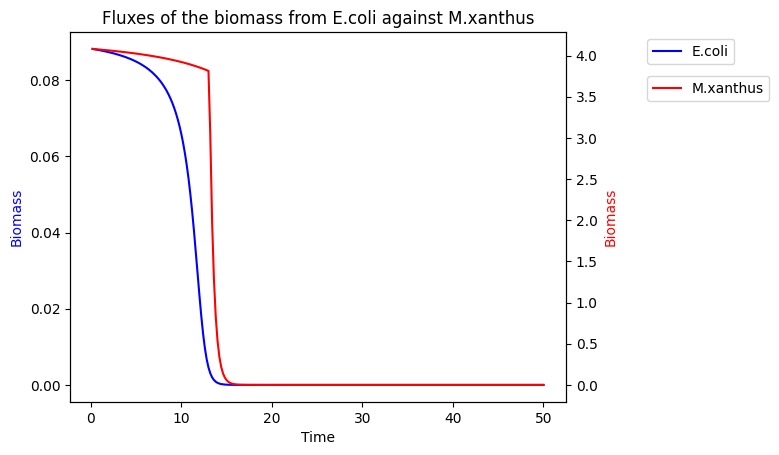

In [21]:
biomass_E = []
biomass_M = []

for i in fluxes_M:
    biomass_M.append(i["OF_BIOMASS"])
for j in fluxes_E:
    biomass_E.append(j['BIOMASS_Ec_iML1515_core_75p37M'])


ax = plt.subplot(111)
ax.plot(time_point[1:], biomass_E, color="b", label="E.coli")
ax2 = plt.twinx(ax)
ax2.plot(time_point[1:], biomass_M, color="r", label="M.xanthus")

ax.set_ylabel("Biomass", color="b")
ax2.set_ylabel("Biomass", color="r")
ax.set_xlabel('Time')

ax.set_title("Fluxes of the biomass from E.coli against M.xanthus")
ax.legend(bbox_to_anchor=(1.15, 1), loc="upper left")
ax2.legend(bbox_to_anchor=(1.15, 0.90), loc="upper left")